In [1]:
import cv2
import numpy as np

from keras.layers import Dense
%matplotlib inline
import keras
from keras.models import Sequential
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import scipy
import math
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank, threshold_adaptive
from skimage import data, filters

import PIL
import billiard
from billiard import Pool
from functools import partial
import pytesseract

Using TensorFlow backend.
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [140]:
def binarize(file=None):
#     img = cv2.imread('../Text-detection-in-natural-scene-images-dataset/text or no text dataset/testing/4833.jpg', 0)
    # Number of rows and columns
    
    img = cv2.imread(file, 0)
    rows = img.shape[0]
    cols = img.shape[1]

    # Convert image to 0 to 1, then do log(1 + I)
    img_log = np.log1p(np.array(img, dtype="float") / 255)

    # Create Gaussian mask of sigma = 10
    M = 2*rows + 1
    N = 2*cols + 1
    sigma = 10
    (X,Y) = np.meshgrid(np.linspace(0,N-1,N), np.linspace(0,M-1,M))
    center_x = np.ceil(N/2)
    center_y = np.ceil(M/2)
    gaussian_numerator = (X - center_x)**2 + (Y - center_y)**2

    # Low pass and high pass filters
    h_low = np.exp(-gaussian_numerator / (2*sigma*sigma))
    h_high = 1 - h_low

    # Move origin of filters so that it's at the top left corner to
    # match with the input image
    h_low_shift = scipy.fftpack.ifftshift(h_low.copy())
    h_high_shift = scipy.fftpack.ifftshift(h_high.copy())


    # Filter the image and crop
    image_filter = scipy.fftpack.fft2(img_log.copy(), (M,N))
    image_outlow = scipy.real(scipy.fftpack.ifft2(image_filter.copy() * h_low_shift, (M,N)))
    image_outhigh = scipy.real(scipy.fftpack.ifft2(image_filter.copy() * h_high_shift, (M,N)))

    # Set scaling factors and add
    gamma1 = 0.3
    gamma2 = 1.5
    image_out = gamma1*image_outlow[0:rows,0:cols] + gamma2*image_outhigh[0:rows,0:cols]

    # Anti-log then rescale to [0,1]
    image_hmf = np.expm1(image_out)
    image_hmf = (image_hmf - np.min(image_hmf)) / (np.max(image_hmf) - np.min(image_hmf))
    image_hmf2 = np.array(255*image_hmf, dtype="uint8")
    
    print("Median, Mean", np.median(image_hmf2, axis=(0,1)), np.mean(image_hmf2, axis=(0,1)))
    mean_value = np.mean(image_hmf2, axis=(0,1))

    # Threshold the image - Anything below intensity (Random) gets set to white
    
    # threshold values = [100, 110, 127]
    image_thresh = image_hmf2 < 127
    image_thresh = 255*image_thresh.astype("uint8")
    
    if mean_value < 127:
        cc = cv2.connectedComponents(np.uint8(cv2.bitwise_not(image_thresh)))[1]
    else:
        cc = cv2.connectedComponents(np.uint8(image_thresh))[1]
 
    fig, axes = plt.subplots(ncols=4, figsize=(20, 10))
    ax = axes.ravel()
    
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')
    
    ax[1].imshow(image_hmf2, cmap=plt.cm.gray)
    ax[1].set_title('Homographic')
    ax[1].axis('off')
    
    ax[2].imshow(image_thresh, cmap=plt.cm.gray)
    ax[2].set_title('Threshold')
    ax[2].axis('off')
    
    ax[3].imshow(cc, cmap=plt.cm.gray)
    ax[3].set_title('CC')
    ax[3].axis('off')

    plt.show()
    
    return cc

In [141]:
def run_preprocessing(frame_location, location="."):
    single_frame_data_dict = {
        "text": "",
        "timestamp_ms": "0"
    }
    
    frame_abs_path = os.path.join(os.path.abspath(location), frame_location)
    frame_no = frame_abs_path.split("/")[-1].split(".")[0]
    img = cv2.imread(frame_abs_path,0)

#     print("*****", img, frame_abs_path)
    
    thresold_frames = os.path.join(location, 'thresold_frames')
    binarized_frames = os.path.join(location, 'binarized_frames')
    
    if not os.path.exists(thresold_frames):
        os.makedirs(thresold_frames)
    if not os.path.exists(binarized_frames):
        os.makedirs(binarized_frames)
        
    
    # Binary thresholding
#     _, img = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
#     cc = cv2.connectedComponents(np.uint8(img))[1]

    # Morph
#     img_blur = cv2.GaussianBlur(img, (3, 3), 0)
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#     img_th = cv2.morphologyEx(img_blur, cv2.MORPH_TOPHAT, kernel)

#     _, img_bin = cv2.threshold(img_th, 0, 255, cv2.THRESH_OTSU) 

#     img_dilate = cv2.dilate(img_bin, kernel)
#     cc = cv2.connectedComponents(np.uint8(img_dilate))[1]
    

    # Adaptive thresholding
#     otsu_1 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
#     img_blur = cv2.GaussianBlur(img, (3, 3), 0)
#     th2 = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11,2)   
#     # connected components
#     cc  = cv2.connectedComponents(np.uint8(th2))[1]

    
    # Local otsu thresholding
#     img_blur = cv2.GaussianBlur(img, (3, 3), 0)
#     radius = 50
#     selem = disk(radius)

#     local_otsu = rank.otsu(img, selem)
#     cc = cv2.connectedComponents(np.uint8(img>=local_otsu))[1]
    
    # Hysteresis
#     edges = filters.sobel(img)
#     low = 0.1
#     high = 0.35
#     lowt = (edges > low).astype(int)


#     hight = (edges > high).astype(int)
#     hyst = filters.apply_hysteresis_threshold(edges, low, high)

#     cc = cv2.connectedComponents(np.uint8(lowt))[1]
    
    cc = binarize(frame_abs_path)
    # creating imgage for every single label in the connected components
    con_img = {}
    for label in np.unique(cc[cc>0]):
        image = np.zeros(cc.shape)
        indices = np.where(cc==label)
        image[indices] = 1
        con_img[label] = image

    tot1=0
    i=1
    mask = {}
    i=1

    loaded_scaler = joblib.load('./model_30k_20k.pkl')
    model = load_model('./model_30k_20k.h5')

    for elem in con_img.keys():
        x,y,w,h = cv2.boundingRect(np.uint8(con_img[elem]))
        #print("****", x, y, w, h)
        imng = img[y:y+h,x:x+w]
        imng =  scipy.misc.imresize(imng,(32,32)).ravel().reshape(1,1024)
        imng = loaded_scaler.transform(imng)
        imng = imng.reshape((1,32,32,1))
        if np.around(model.predict(imng)) == 1.0:
            #print('yuhoo')
            tot1+=con_img[elem]
    #         mask[i]=con_img[elem]
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            i+=1


    thresold_frame = Image.fromarray((cc * 255).astype(np.uint8))
    thresold_frame.save(os.path.join(thresold_frames, 'thresold_' + str(frame_no) + ".jpg"))
    
    binary_frame = Image.fromarray((tot1 * 255).astype(np.uint8))
    binary_frame.save(os.path.join(binarized_frames, 'binary_' + str(frame_no) + ".jpg"))
    
    final_image = cv2.imread(os.path.join(binarized_frames, 'binary_' + str(frame_no) + ".jpg"), 0)
    final_image = cv2.bitwise_not(final_image)
    print(pytesseract.image_to_string(final_image))
    
    return single_frame_data_dict

Median, Mean 100.0 97.24099375


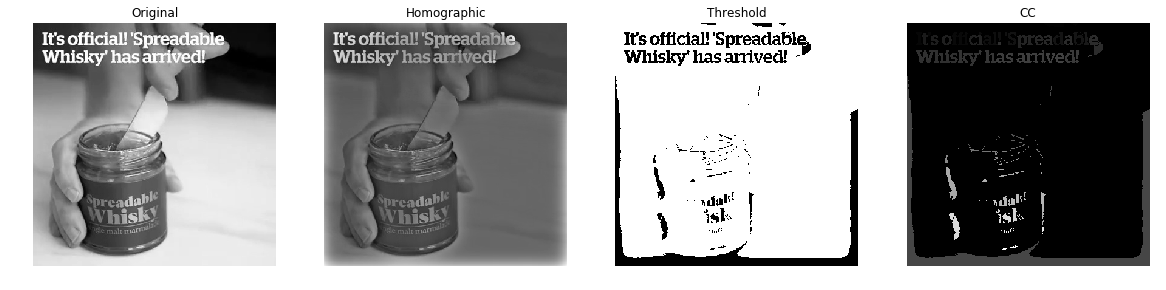

/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


It'soffici ‘Spread bl
Whisky h arrived.


In [144]:
if __name__ == "__main__":
    location = "../Text-detection-in-natural-scene-images-dataset/text or no text dataset/testing/"
    frame = "1080.jpg"
    run_preprocessing(frame_location=frame, location=location)